In [1]:
import argparse
from collections import defaultdict, deque
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv

# Define SOURCE and TARGET constants here...
SOURCE = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))


TARGET_WIDTH = 32
TARGET_HEIGHT = 140

TARGET = np.array(
    [
        [0, 0],
        [TARGET_WIDTH - 1, 0],
        [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
        [0, TARGET_HEIGHT - 1],
    ]
)

CLASS_NAMES = {
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck"
}

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

if __name__ == "__main__":
    video_info = sv.VideoInfo.from_video_path(video_path='./asset/m6-motorway-trim.mp4')
    video_info.fps = 25
    
    model = YOLO("yolov8n.pt")

    byte_track = sv.ByteTrack(
        frame_rate=video_info.fps, track_activation_threshold=0.3
    )

    thickness = sv.calculate_optimal_line_thickness(
        resolution_wh=video_info.resolution_wh
    )
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
    box_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_scale=text_scale,
        text_thickness=thickness,
        text_position=sv.Position.BOTTOM_CENTER,
    )
    trace_annotator = sv.TraceAnnotator(
        thickness=thickness,
        trace_length=video_info.fps * 2,
        position=sv.Position.BOTTOM_CENTER,
    )

    frame_generator = sv.get_video_frames_generator(source_path='./asset/m6-motorway-trim.mp4')

    polygon_zone = sv.PolygonZone(polygon=SOURCE)
    view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

    coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
    vehicle_counts = defaultdict(int)  # Store vehicle counts per category

    with sv.VideoSink('./asset/m6-motorway-trim-result.mp4', video_info) as sink:
        with open('./asset/speed_results.txt', 'w') as f:  
            for frame in frame_generator:
                result = model(frame)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > 0.3]
                detections = detections[polygon_zone.trigger(detections)]
                detections = detections.with_nms(threshold=0.6)
                detections = byte_track.update_with_detections(detections=detections)

                points = detections.get_anchors_coordinates(
                    anchor=sv.Position.BOTTOM_CENTER
                )
                points = view_transformer.transform_points(points=points).astype(int)

                labels = []
                for tracker_id, [_, y], class_id in zip(detections.tracker_id, points, detections.class_id):
                    coordinates[tracker_id].append(y)
                    vehicle_type = CLASS_NAMES.get(class_id, "unknown")

                    if vehicle_type != "unknown":
                        vehicle_counts[vehicle_type] += 1  # Count vehicle types

                    if len(coordinates[tracker_id]) < video_info.fps / 2:
                        labels.append(f"#{tracker_id} {vehicle_type}")
                    else:
                        coordinate_start = coordinates[tracker_id][-1]
                        coordinate_end = coordinates[tracker_id][0]
                        distance = abs(coordinate_start - coordinate_end)
                        time = len(coordinates[tracker_id]) / video_info.fps
                        speed = distance / time * 3.6
                        labels.append(f"#{tracker_id} {vehicle_type} {int(speed)} km/h")

                        # Save categorized speed data
                        f.write(f"Tracker ID: {tracker_id}, Type: {vehicle_type}, Speed: {int(speed)} km/h\n")

                annotated_frame = frame.copy()
                annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
                annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
                annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

                sink.write_frame(annotated_frame)
                cv2.imshow("frame", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break

        # Print vehicle counts
        print("\nVehicle Counts:")
        for vehicle, count in vehicle_counts.items():
            print(f"{vehicle}: {count}")

        cv2.destroyAllWindows()


0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 189.7ms
Speed: 11.5ms preprocess, 189.7ms inference, 19.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 88.0ms
Speed: 2.8ms preprocess, 88.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 75.2ms
Speed: 3.5ms preprocess, 75.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 train, 2 trucks, 73.0ms
Speed: 5.0ms preprocess, 73.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 1 truck, 79.2ms
Speed: 2.0ms preprocess, 79.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 2 trucks, 72.5ms
Speed: 3.5ms preprocess, 72.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 1 truck, 81.3ms
Speed: 3.5ms preprocess, 81.3ms inference, 2.0ms pos

Total vehicles tracked: 166
Average Speed: 55.70 km/h
Maximum Speed: 193 km/h
Minimum Speed: 0 km/h
Median Speed: 40.0 km/h
Speed Standard Deviation: 26.22


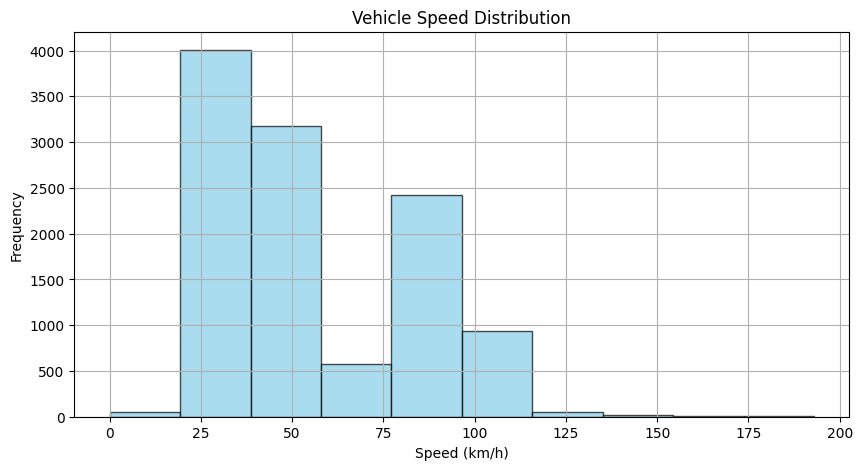

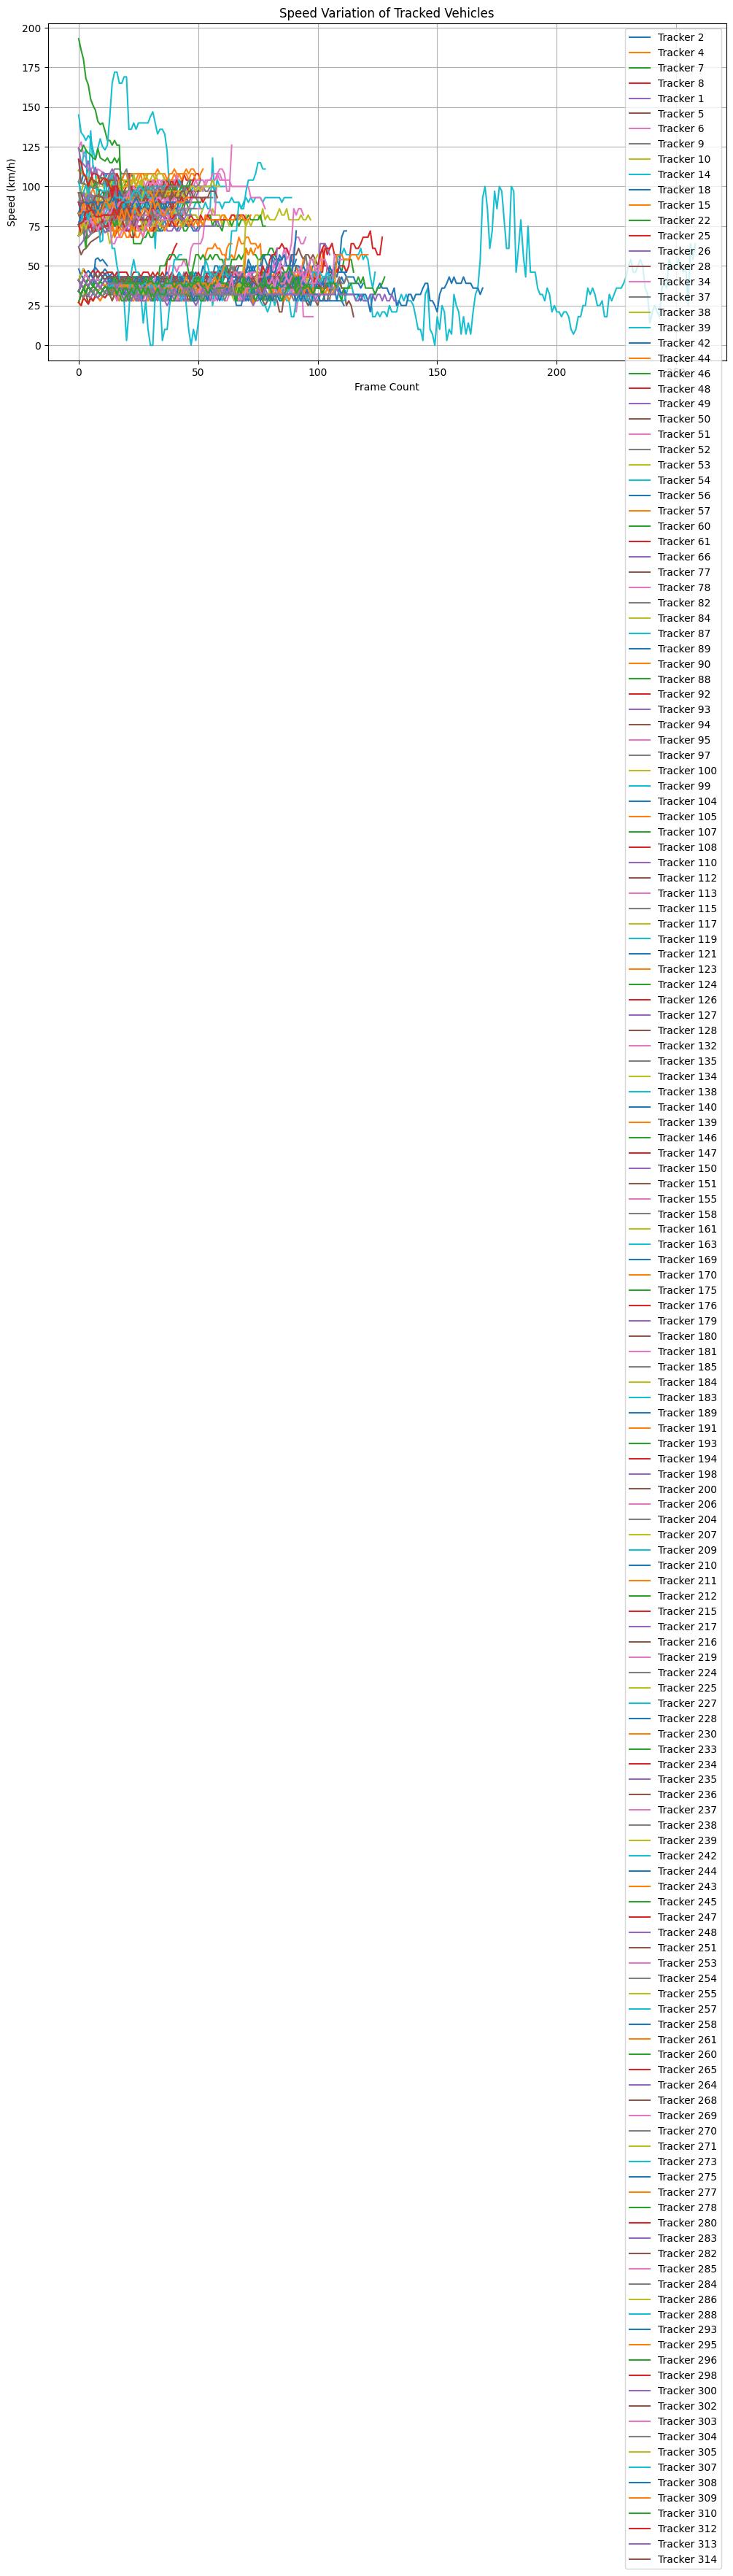

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Path to the saved speed data file
file_path = './asset/speed_results.txt'

# Dictionary to store speed data per vehicle type
vehicle_speeds = defaultdict(list)
vehicle_counts = defaultdict(int)

# Read speed data from the file
with open(file_path, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 3:
            vehicle_type = parts[1].split(":")[1].strip()
            speed = int(parts[2].split(":")[1].strip().split()[0])  # Extract speed value
            vehicle_speeds[vehicle_type].append(speed)
            vehicle_counts[vehicle_type] += 1  # Count vehicles per type

# Compute and print statistics
print("\nVehicle Type Counts:")
for vehicle, count in vehicle_counts.items():
    print(f"{vehicle}: {count}")

print("\nSpeed Statistics by Vehicle Type:")
for vehicle, speeds in vehicle_speeds.items():
    avg_speed = np.mean(speeds)
    max_speed = np.max(speeds)
    min_speed = np.min(speeds)
    print(f"{vehicle} -> Avg: {avg_speed:.2f} km/h, Max: {max_speed} km/h, Min: {min_speed} km/h")

# Plot Speed Distribution by Vehicle Type
plt.figure(figsize=(10, 5))
for vehicle, speeds in vehicle_speeds.items():
    plt.hist(speeds, bins=10, alpha=0.6, label=vehicle)

plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.title('Speed Distribution by Vehicle Type')
plt.legend()
plt.grid(True)
plt.show()



0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 57.5ms
Speed: 4.0ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 train, 2 trucks, 107.5ms
Speed: 5.0ms preprocess, 107.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 2 trucks, 89.6ms
Speed: 5.1ms preprocess, 89.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 1 bus, 1 train, 1 truck, 79.9ms
Speed: 3.0ms preprocess, 79.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 1 truck, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 1 truck, 67.3ms
Speed: 2.0ms preprocess, 67.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 train, 2 trucks, 66.7ms
Speed: 2.0ms preprocess, 66.7ms inference, 0.5ms postprocess p

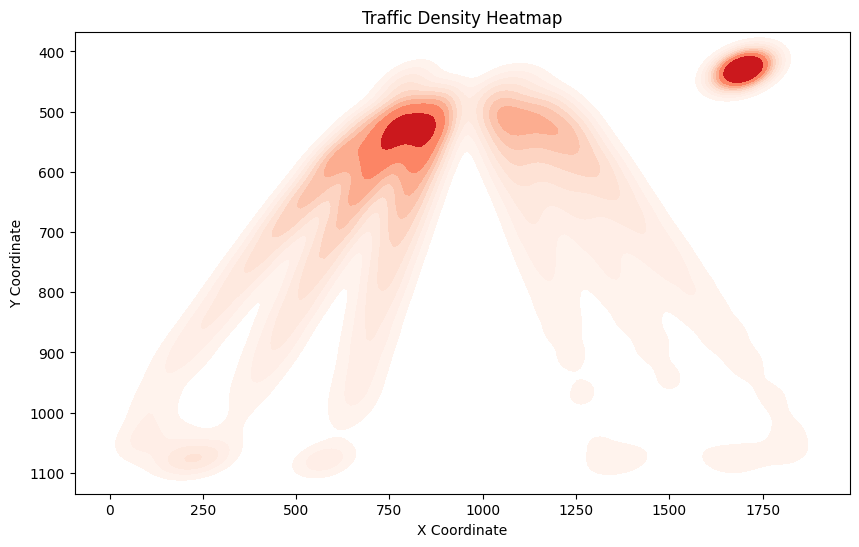

Average Reaction Time: nan
Reaction Time Distribution:
       Reaction Time (s)
count                  0
unique                 0
top                  NaN
freq                 NaN


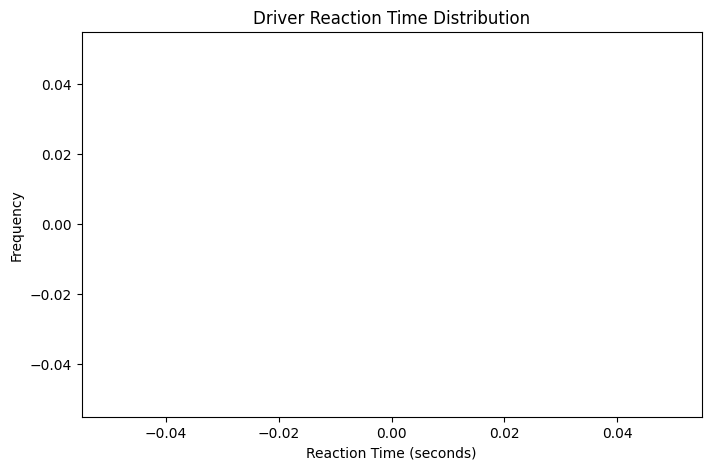

In [ ]:
import cv2
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
import supervision as sv
from collections import defaultdict, deque

# Load YOLO model
model = YOLO("yolov8n.pt")

# Define video source
video_path = "./asset/m6-motorway-trim.mp4"

# Define Stop Line Y-Coordinate
STOP_LINE_Y = 500  
WARNING_ZONE_Y = 300  

# Video Information
video_info = sv.VideoInfo.from_video_path(video_path)
video_info.fps = 25  

# ByteTrack Object Tracker
byte_track = sv.ByteTrack(frame_rate=video_info.fps, track_activation_threshold=0.3)

# Store vehicle movement data
vehicle_data = defaultdict(lambda: {"stopped": False, "stop_time": 0, "reaction_time": None})
reaction_times = []
heatmap_points = []

# Open Video Capture
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 2)  # Reduce buffering for faster processing

frame_count = 0
FRAME_SKIP = 2  # Process every 2nd frame to improve speed

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue  # Skip frames to improve speed

    # Run YOLOv8 Model
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_track.update_with_detections(detections)

    # Analyze each detected vehicle
    for track_id, (x1, y1, x2, y2) in zip(detections.tracker_id, detections.xyxy):
        cx, cy = int((x1 + x2) / 2), int(y2)  # Bottom-center of vehicle
        
        # Save position for heatmap
        heatmap_points.append((cx, cy))

        # Detect stopping at STOP line
        if STOP_LINE_Y - 10 <= cy <= STOP_LINE_Y + 10:
            if not vehicle_data[track_id]["stopped"]:
                vehicle_data[track_id]["stopped"] = True
                vehicle_data[track_id]["stop_time"] = time.time()
        
        # Measure reaction time if moving after STOP
        if vehicle_data[track_id]["stopped"] and cy < WARNING_ZONE_Y:
            if vehicle_data[track_id]["reaction_time"] is None:
                vehicle_data[track_id]["reaction_time"] = time.time() - vehicle_data[track_id]["stop_time"]
                reaction_times.append(vehicle_data[track_id]["reaction_time"])

        # Draw box & tracking info
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, f"ID {track_id}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Show video in real-time
    cv2.imshow("Road-User Behavior Analysis", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Convert data for visualization
df_heatmap = pd.DataFrame(heatmap_points, columns=["x", "y"])
reaction_df = pd.DataFrame(reaction_times, columns=["Reaction Time (s)"])

# Generate heatmap
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df_heatmap["x"], y=df_heatmap["y"], fill=True, bw_adjust=0.5, cmap="Reds")

plt.gca().invert_yaxis()  # Flip y-axis to match video coordinates
plt.title("Traffic Density Heatmap")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

